# Random Forrest Regression

In [30]:
# Import the necessary libraries

import os
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns


from calculate_aqi_london import calculate_aqi

pd.pandas.set_option('display.max_columns', None)

In [5]:
# Loads the dataset
df = pd.read_csv(os.path.join('data', 'air-quality-london-time-of-day.csv'))

# Replace "No data" strings with NaN values in the DataFrame.
df.replace(".", np.nan, inplace=True)
df.replace("", np.nan, inplace=True)

# Convert columns to numeric, coercing non-numeric values to NaN
df['PM2.5_R'] = pd.to_numeric(df['PM2.5_R'], errors='coerce')
df['PM2.5_B'] = pd.to_numeric(df['PM2.5_B'], errors='coerce')

df['PM2.5_diff'] = df['PM2.5_R'] - df['PM2.5_B']
df['PM10_diff'] = df['PM10_R'] - df['PM10_B']
df['NO2_diff'] = df['NO2_R'] - df['NO2_B']
df['SO2_diff'] = df['SO2_R'] - df['SO2_B']
df['O3_diff'] = df['O3_R'] - df['O3_B']

# Extract the hour and month
df['hour'] = pd.to_datetime(df['GMT'], format='%H:%M').dt.hour
df['sin_hour'] = np.sin(2*np.pi*df['hour']/24)
df['cos_hour'] = np.cos(2*np.pi*df['hour']/24)
df['month'] = pd.to_datetime(df['Month'], format='%b-%y').dt.month
df['month_sin'] = np.sin((df['month']-1)*(2.*np.pi/12))
df['month_cos'] = np.cos((df['month']-1)*(2.*np.pi/12))

# Filling NaN values with median of the columns
# numerical features
# num_features = ['PM2.5_B', 'PM10_B', 'NO2_B', 'O3_B']
# num_features = ["PM2.5_r", "PM10_r", "NO2_r", "O3_r", "SO2_r"]
num_features = ["PM2.5_B", "PM10_B", "NOx_B", "NO2_B", "SO2_B", "O3_B","PM2.5_R", "PM10_R", "NOx_R", "NO2_R", "SO2_R", "O3_R", "PM2.5_diff", "PM10_diff", "NO2_diff", "SO2_diff", "O3_diff", "sin_hour", "cos_hour", "month", 'month_sin', 'month_cos']
num_imputer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean', missing_values=np.nan))])

# categorical features
# actual categorical features if they should be considered
cat_imputer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent'))])
cat_features = []

# preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_imputer, num_features),
        ('cat', cat_imputer, cat_features)])

df = pd.DataFrame(preprocessor.fit_transform(df), columns=num_features+cat_features)

In [23]:
df

,PM2.5_B,PM10_B,NOx_B,NO2_B,SO2_B,O3_B,PM2.5_R,PM10_R,NOx_R,NO2_R,SO2_R,O3_R,PM2.5_diff,PM10_diff,NO2_diff,SO2_diff,O3_diff,sin_hour,cos_hour,month,month_sin,month_cos
0,13.29463,19.2,55.532283,34.2,3.1,41.8,15.5,23.0,136.866884,42.3,3.4,32.6,2.21142,3.8,8.1,0.3,-9.2,0.000000,1.000000,1.0,0.000000e+00,1.0
1,13.29463,18.9,55.532283,29.0,3.1,45.3,13.5,21.2,136.866884,33.8,2.6,35.3,2.21142,2.3,4.8,-0.5,-10.0,0.258819,0.965926,1.0,0.000000e+00,1.0
2,13.29463,17.7,55.532283,25.4,3.3,46.6,12.7,19.6,136.866884,28.8,2.1,43.2,2.21142,1.9,3.4,-1.2,-3.4,0.500000,0.866025,1.0,0.000000e+00,1.0
3,13.29463,16.4,55.532283,23.4,3.3,46.6,11.9,18.3,136.866884,27.3,2.0,42.4,2.21142,1.9,3.9,-1.3,-4.2,0.707107,0.707107,1.0,0.000000e+00,1.0
4,13.29463,16.0,55.532283,24.2,2.8,45.2,12.0,18.1,136.866884,29.4,2.2,40.1,2.21142,2.1,5.2,-0.6,-5.1,0.866025,0.500000,1.0,0.000000e+00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3331,9.10000,14.4,22.800000,19.7,2.5,60.6,10.1,18.5,66.300000,37.7,5.1,34.4,1.00000,4.1,18.0,2.6,-26.2,-0.965926,0.258819,7.0,1.224647e-16,-1.0
3332,9.40000,13.8,23.900000,21.0,2.5,55.8,10.8,18.4,65.500000,38.3,5.0,31.8,1.40000,4.6,17.3,2.5,-24.0,-0.866025,0.500000,7.0,1.224647e-16,-1.0
3333,9.50000,14.2,26.200000,23.0,2.5,50.4,10.7,18.5,67.300000,39.4,5.8,29.4,1.20000,4.3,16.4,3.3,-21.0,-0.707107,0.707107,7.0,1.224647e-16,-1.0
3334,9.40000,14.5,25.700000,22.5,2.5,46.7,9.6,18.0,62.000000,37.5,5.7,28.4,0.20000,3.5,15.0,3.2,-18.3,-0.500000,0.866025,7.0,1.224647e-16,-1.0


In [9]:
# df['AQI'] = df.apply(calculate_aqi, axis=1)
df['AQI_R'], df['AQI_B'] = zip(*df.apply(calculate_aqi, axis=1))
df['AQI'] = df[['AQI_R', 'AQI_B']].mean(axis=1)

features = ["PM2.5_B", "PM10_B", "NO2_B", "SO2_B", "O3_B", "PM2.5_R", "PM10_R", "NO2_R", "SO2_R", "O3_R", "PM2.5_diff", "PM10_diff", "NO2_diff", "SO2_diff", "O3_diff", "sin_hour", "cos_hour",'month_sin', 'month_cos']
X = df[features]
y = df['AQI']

# Splitting data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


# Model initialization
# model = RandomForestRegressor(n_estimators=100, random_state=42)
#model = Pipeline(steps=[('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])
model = Pipeline(steps=[('regressor', LinearRegression())])

# Fitting model to training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 15.067102290679946


##### 1. **Calculation**:
   ```python
   mse_linear = mean_squared_error(y_test, predictions_linear) 15
   mse_rf = mean_squared_error(y_test, predictions_rf) 1.14
   mse_difference = mse_linear - mse_rf
   print(f'Mean Squared Error for Linear Regression: {mse_linear}')
   print(f'Mean Squared Error for Random Forest: {mse_rf}')
   print(f'Difference in Mean Squared Error: {mse_difference}')
   ```

2. **Interpretation**:
   - **Positive Difference**: If `mse_difference` is positive, it means the linear regression model has a higher error, and thus the random forest is performing better.
   - **Negative Difference**: If `mse_difference` is negative, it means the linear regression model has a lower error, and thus it's performing better.
   - **Close to Zero**: If `mse_difference` is close to zero, both models have a similar error rate, and neither has a clear advantage in terms of this metric.

In [10]:
import time
from joblib import dump

start_time = time.time()

# Save the model as a pickle in a file
dump(model, 'random_forest_model_uk_avg.joblib')
dump(scaler, 'scaler.joblib')

print("Model saved in %s seconds" % (time.time() - start_time))


Model saved in 0.0109710693359375 seconds


In [11]:
df.head()

,PM2.5_B,PM10_B,NOx_B,NO2_B,SO2_B,O3_B,PM2.5_R,PM10_R,NOx_R,NO2_R,SO2_R,O3_R,PM2.5_diff,PM10_diff,NO2_diff,SO2_diff,O3_diff,sin_hour,cos_hour,month,month_sin,month_cos,AQI_R,AQI_B,AQI
0,13.29463,19.2,55.532283,34.2,3.1,41.8,15.5,23.0,136.866884,42.3,3.4,32.6,2.21142,3.8,8.1,0.3,-9.2,0.000000,1.000000,1.0,0.0,1.0,53,43,48.0
1,13.29463,18.9,55.532283,29.0,3.1,45.3,13.5,21.2,136.866884,33.8,2.6,35.3,2.21142,2.3,4.8,-0.5,-10.0,0.258819,0.965926,1.0,0.0,1.0,42,36,39.0
2,13.29463,17.7,55.532283,25.4,3.3,46.6,12.7,19.6,136.866884,28.8,2.1,43.2,2.21142,1.9,3.4,-1.2,-3.4,0.500000,0.866025,1.0,0.0,1.0,36,32,34.0
3,13.29463,16.4,55.532283,23.4,3.3,46.6,11.9,18.3,136.866884,27.3,2.0,42.4,2.21142,1.9,3.9,-1.3,-4.2,0.707107,0.707107,1.0,0.0,1.0,34,29,31.5
4,13.29463,16.0,55.532283,24.2,2.8,45.2,12.0,18.1,136.866884,29.4,2.2,40.1,2.21142,2.1,5.2,-0.6,-5.1,0.866025,0.500000,1.0,0.0,1.0,37,30,33.5


In [12]:
df.head()

,PM2.5_B,PM10_B,NOx_B,NO2_B,SO2_B,O3_B,PM2.5_R,PM10_R,NOx_R,NO2_R,SO2_R,O3_R,PM2.5_diff,PM10_diff,NO2_diff,SO2_diff,O3_diff,sin_hour,cos_hour,month,month_sin,month_cos,AQI_R,AQI_B,AQI
0,13.29463,19.2,55.532283,34.2,3.1,41.8,15.5,23.0,136.866884,42.3,3.4,32.6,2.21142,3.8,8.1,0.3,-9.2,0.000000,1.000000,1.0,0.0,1.0,53,43,48.0
1,13.29463,18.9,55.532283,29.0,3.1,45.3,13.5,21.2,136.866884,33.8,2.6,35.3,2.21142,2.3,4.8,-0.5,-10.0,0.258819,0.965926,1.0,0.0,1.0,42,36,39.0
2,13.29463,17.7,55.532283,25.4,3.3,46.6,12.7,19.6,136.866884,28.8,2.1,43.2,2.21142,1.9,3.4,-1.2,-3.4,0.500000,0.866025,1.0,0.0,1.0,36,32,34.0
3,13.29463,16.4,55.532283,23.4,3.3,46.6,11.9,18.3,136.866884,27.3,2.0,42.4,2.21142,1.9,3.9,-1.3,-4.2,0.707107,0.707107,1.0,0.0,1.0,34,29,31.5
4,13.29463,16.0,55.532283,24.2,2.8,45.2,12.0,18.1,136.866884,29.4,2.2,40.1,2.21142,2.1,5.2,-0.6,-5.1,0.866025,0.500000,1.0,0.0,1.0,37,30,33.5


**Avg Prediction**

In [25]:
from joblib import load
import pandas as pd
import numpy as np

scaler = load('scaler.joblib')
model = load('random_forest_model_uk_avg.joblib')

# Create a DataFrame with the future values of the features
future_data = pd.DataFrame({
    'PM2.5_B': [13.29463],
    'PM10_B': [19.2],
    'NO2_B': [34.2],
    'SO2_B': [3.1],
    'O3_B': [41.8],
    'PM2.5_R': [15.5],
    'PM10_R': [23.0],
    'NO2_R': [42.3],
    'SO2_R': [3.4],
    'O3_R': [32.6],
    'hour': [15],  # Change with the correct hour value
    'month': [7]   # Change with the correct month value
})

# Calculate the differences between Roadside and Background values
future_data['PM2.5_diff'] = future_data['PM2.5_R'] - future_data['PM2.5_B']
future_data['PM10_diff'] = future_data['PM10_R'] - future_data['PM10_B']
future_data['NO2_diff'] = future_data['NO2_R'] - future_data['NO2_B']
future_data['SO2_diff'] = future_data['SO2_R'] - future_data['SO2_B']
future_data['O3_diff'] = future_data['O3_R'] - future_data['O3_B']

# Apply cyclical encoding
hours_in_day = 24
months_in_year = 12
future_data['sin_hour'] = np.sin(2*np.pi*future_data.hour/hours_in_day)
future_data['cos_hour'] = np.cos(2*np.pi*future_data.hour/hours_in_day)
future_data['month_sin'] = np.sin((future_data['month']-1)*(2.*np.pi/months_in_year))
future_data['month_cos'] = np.cos((future_data['month']-1)*(2.*np.pi/months_in_year))

# Drop 'hour' and 'month' as they've been replaced with their cyclical encoding
future_data.drop(columns=['hour', 'month'], inplace=True)

columns = ["PM2.5_B", "PM10_B", "NO2_B", "SO2_B", "O3_B","PM2.5_R", "PM10_R", "NO2_R", "SO2_R", "O3_R", "PM2.5_diff", "PM10_diff", "NO2_diff", "SO2_diff", "O3_diff", "sin_hour", "cos_hour", 'month_sin', 'month_cos']
future_data = future_data[columns]

# Scale the features
future_data_scaled = pd.DataFrame(scaler.transform(future_data), columns=columns)

# Use the model to make the prediction
future_prediction = model.predict(future_data_scaled)

# Print the prediction
print(f'The predicted AQI for the future data is {future_prediction[0]}')


The predicted AQI for the future data is 46.98783968203191


The difference between predicted AQI (Air Quality Index) from different models such as linear regression and random forest can give you insights into how each model is capturing the relationships in the data.

Here's what you might infer:

1. **Differences in Predicted Values**: Compare the predicted AQI values from both models to understand where they agree and where they differ. You might find that one model performs better in certain regions of the input space (e.g., for specific times of the day, or certain pollutants).

2. **Visualization**: A scatter plot or line chart comparing the predicted AQI from both models against the actual AQI can be insightful. You might see where one model is over or under-predicting compared to the other.

   ```python
   plt.scatter(y_test, predictions_linear, label='Linear Regression')
   plt.scatter(y_test, predictions_rf, label='Random Forest')
   plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
   plt.xlabel('Actual')
   plt.ylabel('Predicted')
   plt.legend()
   plt.show()
   ```

3. **Model Complexity**: Linear regression will typically capture linear relationships between features and AQI, while random forest can model more complex, non-linear relationships. If the relationship between the features and AQI is inherently non-linear, the random forest might be expected to perform better.

4. **Residual Analysis**: You can also look at the differences in the residuals (the difference between predicted and actual values) for both models. This can reveal biases in how each model is predicting AQI.

5. **Statistical Measures**: Beyond visual inspection, you can apply statistical measures like correlation coefficients, paired t-tests, etc., to quantify the differences between the predictions of the two models.

6. **Practical Implications**: Consider the real-world context of predicting AQI. Small differences might not be meaningful, while larger differences might have substantial implications for public health or regulatory compliance.

7. **Error Analysis**: Investigate specific instances where the models' predictions differ substantially. Are there common characteristics or patterns? This could lead to insights about what features or interactions are not being captured by one or both models.

In summary, the difference in predicted AQI between linear regression and random forest can reveal important insights into how each model is operating. By investigating these differences visually, statistically, and contextually, you can gain a better understanding of each model's strengths and weaknesses and identify opportunities for model improvement or selection.

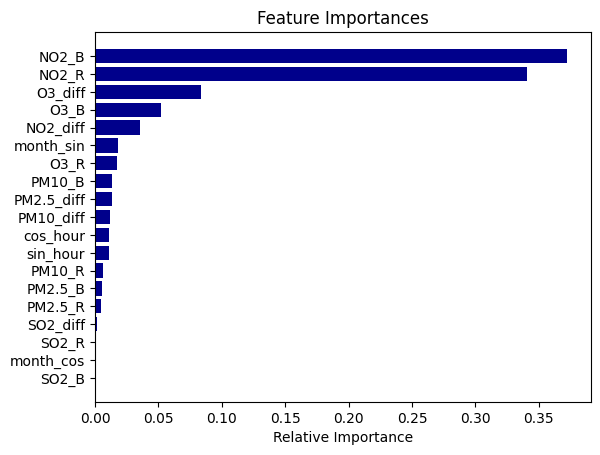

In [22]:
import matplotlib.pyplot as plt

# Get coefficients from the linear regression model
coefficients = model.named_steps['regressor'].coef_

# Normalize the coefficients to sum to 1, similar to random forest feature importances
normalized_coefficients = np.abs(coefficients) / np.sum(np.abs(coefficients))

# Get feature names
features = X.columns

# Sort the normalized coefficients
indices = np.argsort(normalized_coefficients)

plt.title('Feature Importances')
plt.barh(range(len(indices)), normalized_coefficients[indices], color='DarkBlue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()



The difference in the "importance" bars between linear regression and random forest models stems from fundamental differences in how these models work and how they evaluate the importance of features. Here's a breakdown:

1. **Model Assumptions**:
   - **Linear Regression**: Assumes a linear relationship between features and target. The coefficients represent the change in the target variable for a one-unit change in the feature, assuming all other features are held constant. A larger absolute coefficient value means that feature has a larger effect on the target variable.
   - **Random Forest**: It's a non-linear model that uses ensembles of decision trees. Feature importance is determined by looking at how much each feature decreases the impurity (e.g., Gini impurity or entropy) across all trees in the forest. A higher importance means that splitting the data based on that feature results in purer nodes.

2. **Scaling of Features**:
   - In linear regression, the magnitude of the coefficients is influenced by the scale of the features. If features are not standardized, a feature with a large scale could have a small coefficient simply because of its scale, not because it's unimportant.
   - Random Forest is scale-independent, and the importance of a feature is not directly affected by its scale.

3. **Interactions and Non-linearities**:
   - Random Forest can naturally capture complex interactions and non-linearities, and these can affect feature importances.
   - Linear regression cannot capture these effects (unless polynomial or interaction terms are explicitly added), so features that contribute through non-linear relationships or interactions might seem less important.

4. **Robustness to Outliers and Collinearity**:
   - Linear regression can be sensitive to outliers and collinearity (when features are highly correlated with each other), and this can affect the coefficients.
   - Random Forest is generally more robust to these issues.

Because of these differences, the two models might give quite different importance values for the same features. Neither approach is "right" or "wrong" in an absolute sense, but each provides a different perspective on the data. If you see significant discrepancies between the models, it may be an indication that there are non-linearities, interactions, or other complex patterns in the data, and further exploration and understanding of these might be warranted.

In [26]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

R-squared: 0.9229563092492354


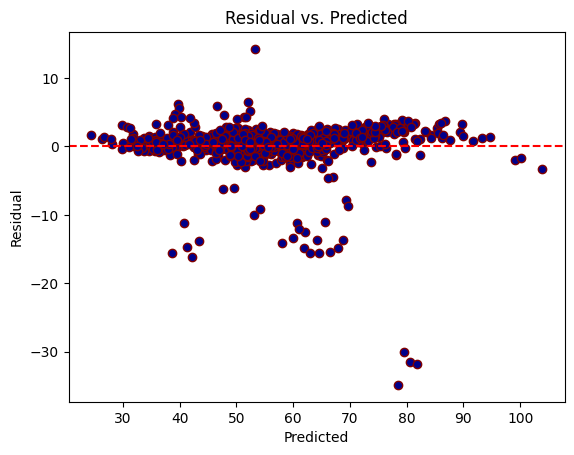

In [27]:
import matplotlib.pyplot as plt
residuals = y_test - predictions
plt.scatter(predictions, residuals, marker='o', c='DarkBlue', edgecolors='maroon')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual vs. Predicted')
plt.show()


The plot of residuals (i.e., the differences between actual and predicted values) versus predicted values is a powerful diagnostic tool for understanding the behavior of a regression model. Here's how you might interpret such plots for linear regression and random forest models:

### Linear Regression:

1. **Homoscedasticity**: Ideally, you want the residuals to be evenly spread across all levels of the predicted values, forming a horizontal "cloud" around the zero line. This condition is known as homoscedasticity, and it indicates that the model's errors are consistent across the range of predicted values.

2. **Heteroscedasticity**: If you see a pattern in the residuals, such as a funnel shape where the spread of residuals increases or decreases as the predicted value changes, this is a sign of heteroscedasticity. It could indicate that the model's performance varies at different levels of the dependent variable, and it might violate the assumptions of constant variance in linear regression.

3. **Outliers**: Outliers may appear as individual points that are far away from the zero line. These can unduly influence the model's coefficients.

### Random Forest:

1. **Non-linear Patterns**: Random Forest can capture complex, non-linear relationships. Thus, a well-fitting random forest model might show no discernible pattern in the residuals vs. predicted plot. However, overfitting to the training data might manifest as an increased spread of residuals on the test data.

2. **Robustness to Heteroscedasticity**: Random Forest doesn't make the same assumptions about the error variance as linear regression, so it might be more robust to heteroscedasticity. However, patterns or trends in the residuals could still indicate that the model is not fully capturing the underlying relationship.



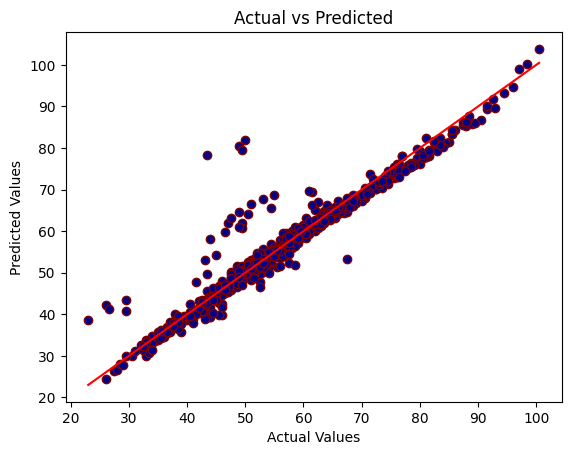

In [28]:
plt.scatter(y_test, predictions, c='DarkBlue', edgecolors='maroon')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.title('Actual vs Predicted')
plt.show()

The comparison between actual and predicted values is a common way to visually assess how well a regression model is performing. It helps you to see where the model is making accurate predictions and where it's going awry. Let's break down what you might observe for both linear regression and random forest models.

### Linear Regression:

- **Straight-Line Relationship**: If the model is well-fitted, the actual vs predicted plot may closely follow a straight line. Deviations from this line indicate errors in prediction.
- **Homoscedasticity**: Ideally, the spread of residuals (differences between actual and predicted) is constant across all levels of the predicted values.
- **Outliers and Leverage**: Outliers might appear as distinct deviations from the line, and high-leverage points can unduly influence the regression line.

### Random Forest:

- **Non-linear Patterns**: Random Forest can capture complex, non-linear relationships, so the actual vs predicted plot might show a more complex pattern that doesn't necessarily follow a straight line.
- **Variance and Bias**: Random Forest can adapt to intricate structures in the data, but it might also overfit, especially if it's too complex. This could be seen as the model fitting the noise in the training data and might manifest as increased variance in the actual vs predicted plot on test data.
- **Robustness**: Generally more robust to outliers and multi-collinearity, which might lead to a more consistent performance across different parts of the data.


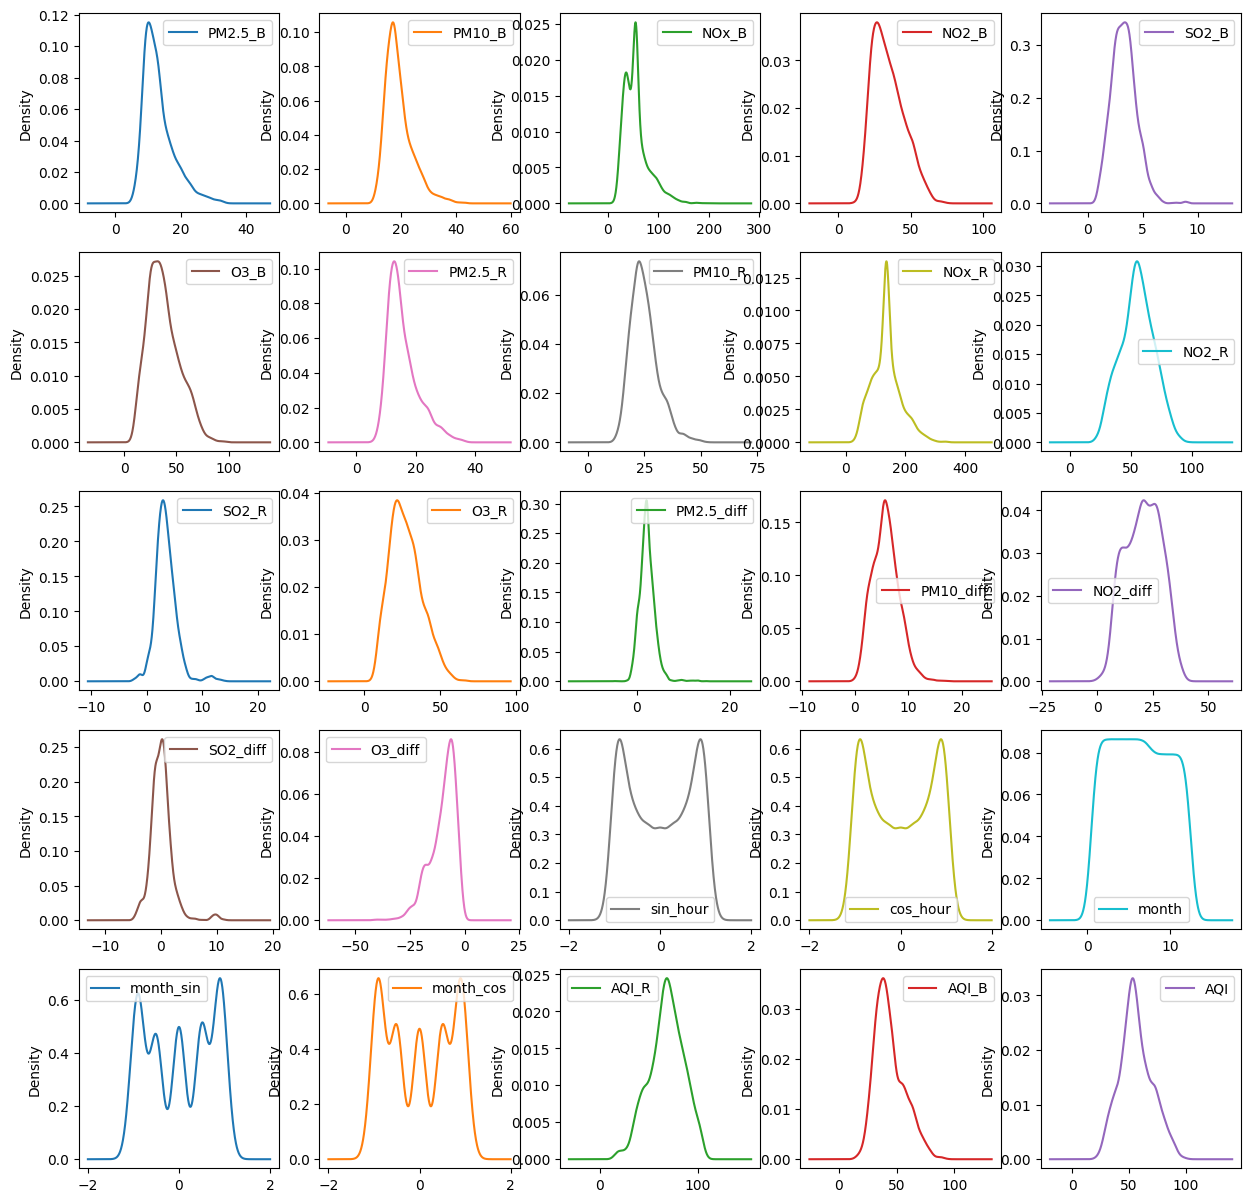

In [32]:
#density plots
df.plot(kind='density', subplots=True, layout=(5,5), sharex=False, figsize=(15,15))
plt.show()

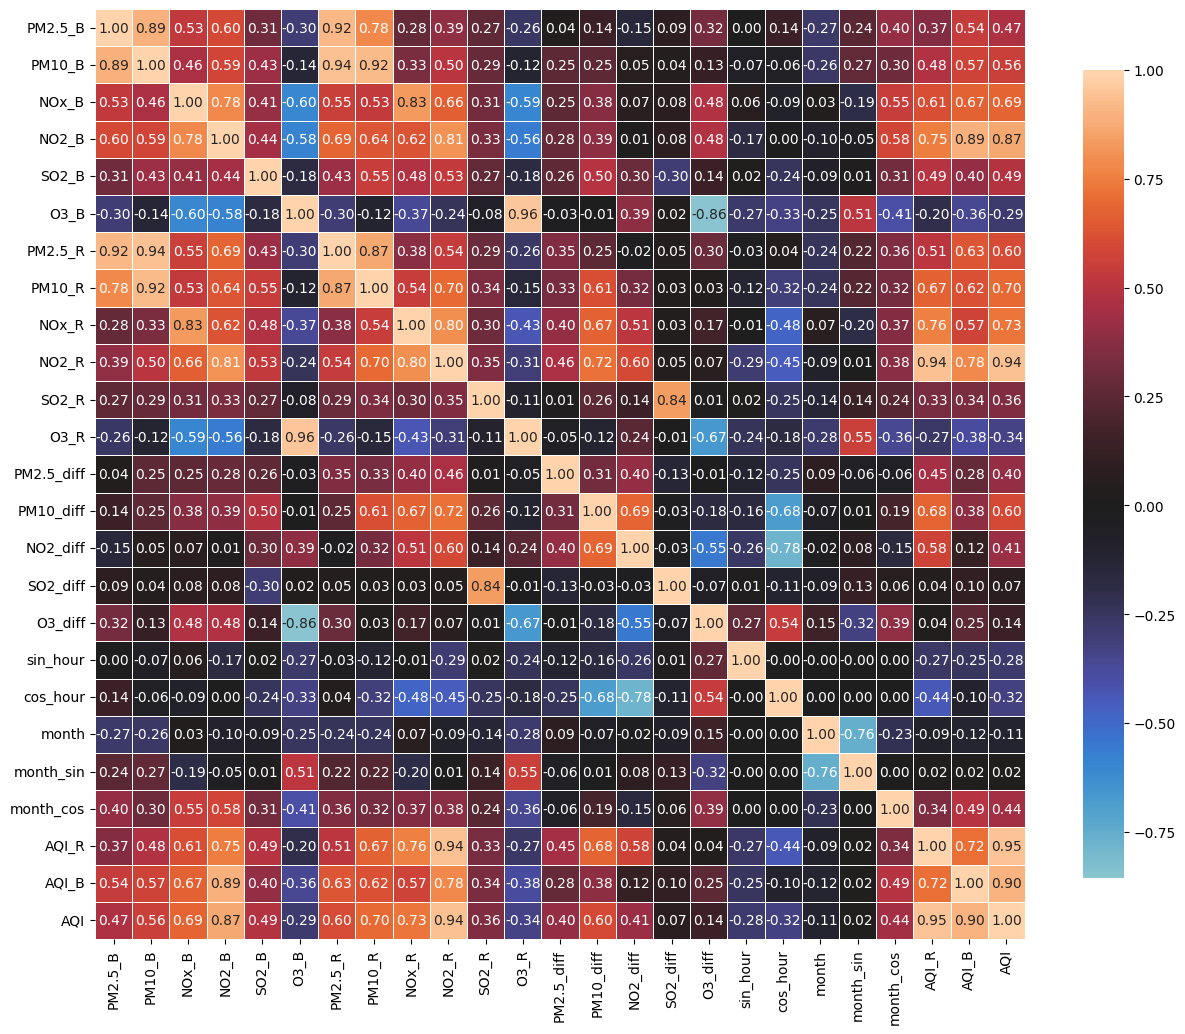

In [31]:
correlations = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();